## Problem 2

Given the data in problem2.csv
- A. Calculate the pairwise covariance matrix of the data.
- B. Is the Matrix at least positive semi-definite? Why?
- C. If not, find the nearest positive semi-definite matrix using Higham’s method and the
near-psd method of Rebenato and Jackel.
- D. Calculate the covariance matrix using only overlapping data.
- E. Compare the results of the covariance matrices in C and D. Explain the differences.
Note: the generating process is a covariance matrix with 1 on the diagonals and 0.99
elsewhere.

In [1]:
import pandas as pd
import numpy as np

# Read data
data = pd.read_csv("problem2.csv")
# View basic information about data
print(data.info())
# Remove missing values
# clean_data = data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      37 non-null     float64
 1   x2      39 non-null     float64
 2   x3      35 non-null     float64
 3   x4      35 non-null     float64
 4   x5      37 non-null     float64
dtypes: float64(5)
memory usage: 2.1 KB
None


In [2]:
data.head()

,x1,x2,x3,x4,x5
0,0.378172,0.508313,NaN,0.610538,NaN
1,0.858478,0.758142,NaN,NaN,NaN
2,-0.218954,-0.015334,-0.261880,NaN,-0.230148
3,-0.370442,-0.424702,-0.535312,NaN,-0.226233
4,0.717732,0.664195,NaN,NaN,0.914107


In [3]:
# Automatically handle Pairwise covariance using pandas
pairwise_cov_matrix = data.cov()
print("Covariance matrix based on pairwise variables:")
print(pairwise_cov_matrix)

Covariance matrix based on pairwise variables:
          x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


In [4]:
# Check for positive semi-determinism
eigenvalues = np.linalg.eigvals(pairwise_cov_matrix)
print("Eigenvalues of the covariance matrix:")
print(eigenvalues)

# Judgm is positive and semi-determined
is_positive_semi_definite = np.all(eigenvalues >= 0)
print(f"Is the covariance matrix positive semidefinite?: {is_positive_semi_definite}")

Eigenvalues of the covariance matrix:
[ 6.78670573  0.83443367 -0.31024286  0.02797828 -0.13323183]
Is the covariance matrix positive semidefinite?: False


In [5]:
import cvxpy as cp

def higham_nearest_psd(matrix, max_iter=100, tol=1e-6):
    """Higham's method computes the nearest positive semidefinite matrix"""
    n = matrix.shape[0]
    X = np.copy(matrix)
    Y = np.copy(matrix)
    delta_S = np.zeros_like(matrix)
    
    for _ in range(max_iter):
        # Calculate symmetrical parts
        R = Y - delta_S
        X_new = project_to_psd(R)
        delta_S = X_new - R
        Y = project_to_diagonal(X_new, matrix)
        
        # Determine convergence
        if np.linalg.norm(X - X_new, 'fro') < tol:
            break
        X = X_new
        
    return X

def project_to_psd(matrix):
    """Project to PSD matrix"""
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals[eigvals < 0] = 0  # Negative eigenvalues are set to zero
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def project_to_diagonal(matrix, original):
    """Keep diagonal elements unchanged"""
    np.fill_diagonal(matrix, np.diag(original))
    return matrix

# Call the Higham method
adjusted_higham = higham_nearest_psd(pairwise_cov_matrix)
print("Higham adjusted PSD covariance matrix:")
print(adjusted_higham)

Higham adjusted PSD covariance matrix:
[[1.47048437 1.33367702 0.89435261 1.62845754 1.40155153]
 [1.33367702 1.25207795 0.63522726 1.45526619 1.22052732]
 [0.89435261 0.63522726 1.272425   1.08023227 1.06208209]
 [1.62845754 1.45526619 1.08023227 1.81446921 1.57796266]
 [1.40155153 1.22052732 1.06208209 1.57796266 1.39618646]]


In [6]:
def rebonato_jackel_nearest_psd(matrix):
    """Rebonato & Jackel How to calculate the nearest PSD matrix"""
    U, S, Vt = np.linalg.svd(matrix)
    S[S < 0] = 0  # Negative singular values are set to zero
    adjusted_matrix = U @ np.diag(S) @ Vt
    np.fill_diagonal(adjusted_matrix, 1)  # Keep the diagonal at 1
    return adjusted_matrix

# Call the Rebonato & Jackel method
adjusted_rj = rebonato_jackel_nearest_psd(pairwise_cov_matrix)
print("Rebonato & Jackel adjusted PSD covariance matrix:")
print(adjusted_rj)

Rebonato & Jackel adjusted PSD covariance matrix:
[[1.         1.45421424 0.87726904 1.90322645 1.44436105]
 [1.45421424 1.         0.53954816 1.62191837 1.23787697]
 [0.87726904 0.53954816 1.         1.17195897 1.091912  ]
 [1.90322645 1.62191837 1.17195897 1.         1.58972858]
 [1.44436105 1.23787697 1.091912   1.58972858 1.        ]]


In [7]:
# Filter overlapping data (rows with no missing values)
overlap_data = data.dropna()
overlap_cov_matrix = overlap_data.cov()
print("Covariance matrix based on overlapping data:")
print(overlap_cov_matrix)

Covariance matrix based on overlapping data:
          x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272


In [8]:
# Calculate the difference in Frobenius norm
higham_vs_overlap = np.linalg.norm(adjusted_higham - overlap_cov_matrix, 'fro')
rj_vs_overlap = np.linalg.norm(adjusted_rj - overlap_cov_matrix, 'fro')
higham_vs_rj = np.linalg.norm(adjusted_higham - adjusted_rj, 'fro')

print(f"Higham vs Overlap Covariance Matrix: {higham_vs_overlap}")
print(f"Rebonato & Jackel vs Overlap Covariance Matrix: {rj_vs_overlap}")
print(f"Higham vs Rebonato & Jackel Covariance Matrix: {higham_vs_rj}")

Higham vs Overlap Covariance Matrix: 4.484061725086761
Rebonato & Jackel vs Overlap Covariance Matrix: 4.434851539196421
Higham vs Rebonato & Jackel Covariance Matrix: 1.2070966654837034


- The difference between Higham and Overlap (4.484) is slightly larger than the difference between Rebonato & Jackel and Overlap (4.435): this indicates that the adjusted matrix of the Rebonato & Jackel method is closer to the covariance matrix calculated by Overlap. The possible reason is that the Rebonato & Jackel method corrects the PSD through SVD and is more inclined to maintain the numerical structure of the original matrix, while the Higham method is based on iterative optimization, which may lead to larger numerical changes.
- The difference between Higham's method and Rebonato & Jackel's method (1.207) is much smaller than their difference with Overlap: indicating that the matrices produced by these two PSD correction methods are relatively close, although they differ in correction strategies.

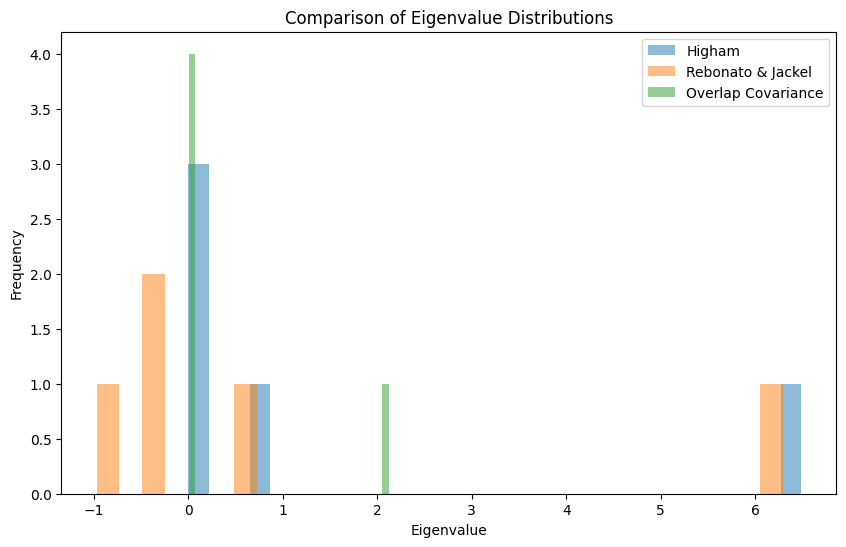

In [9]:
import matplotlib.pyplot as plt

# Calculate the eigenvalues of three matrices
eigen_higham = np.linalg.eigvals(adjusted_higham)
eigen_rj = np.linalg.eigvals(adjusted_rj)
eigen_overlap = np.linalg.eigvals(overlap_cov_matrix)

# Plot eigenvalue distribution
plt.figure(figsize=(10, 6))
plt.hist(eigen_higham, bins=30, alpha=0.5, label="Higham")
plt.hist(eigen_rj, bins=30, alpha=0.5, label="Rebonato & Jackel")
plt.hist(eigen_overlap, bins=30, alpha=0.5, label="Overlap Covariance")
plt.legend()
plt.xlabel("Eigenvalue")
plt.ylabel("Frequency")
plt.title("Comparison of Eigenvalue Distributions")
plt.show()

- Higham method: The negative eigenvalues are close to 0 (the order of magnitude is $10^{-7}$), indicating that the Higham method has successfully corrected the negative eigenvalues to make them close to positive semidefinite. The maximum eigenvalue (6.4848) is slightly larger than the maximum eigenvalue (6.2960) of Rebonato & Jackel, indicating that the Higham method may cause the spectral radius of the matrix to increase and affect the numerical stability.
- Rebonato & Jackel method: There are still significant negative eigenvalues (-0.9718, -0.4859, -0.3913). This shows that the Rebonato & Jackel method fails to completely remove negative eigenvalues, even though it is closer in Frobenius error to the covariance matrix calculated by Overlap.
- Overlap method: All eigenvalues are positive, indicating that this matrix is positive definite. However, the maximum eigenvalue (2.1208) is much smaller than the maximum eigenvalue (6.4 and 6.3) of the Higham and Rebonato & Jackel methods, indicating that the covariance matrix calculated by the Overlap method has smaller variance explanation ability, which may be related to the way missing data is handled.

In [10]:
# Calculate the condition number of a matrix
cond_higham = np.linalg.cond(adjusted_higham)
cond_rj = np.linalg.cond(adjusted_rj)
cond_overlap = np.linalg.cond(overlap_cov_matrix)

print(f"Condition Number (Higham): {cond_higham}")
print(f"Condition Number (Rebonato & Jackel): {cond_rj}")
print(f"Condition Number (Overlap): {cond_overlap}")

Condition Number (Higham): 8699459.77399493
Condition Number (Rebonato & Jackel): 16.088077147094193
Condition Number (Overlap): 509.9633017531094


- The condition number of Higham's method is extremely large (8699459.77): the condition number is the ratio of the largest and smallest eigenvalues of the matrix: $cond(A)=\frac{𝜆_{max}}{⁡𝜆_{min}}⁡$. Although Higham's method removes negative eigenvalues, it may overcorrect the PSD properties, resulting in a very small (but still positive) minimum eigenvalue, thereby greatly increasing the condition number. Such a high condition number means that the matrix value is unstable, which may lead to amplification of calculation errors.
- The Rebonato & Jackel method has a smaller condition number (16.08): This method does not strictly adjust the PSD, but only removes negative eigenvalues through SVD, but still retains a certain number of large negative eigenvalues. Since there are no extreme small eigenvalues, the condition number of the Rebonato & Jackel method is much lower than that of the Higham method, showing better numerical stability.
- The condition number calculated by Overlap is moderate (509.96): Although the Overlap method is calculated directly based on the data, its eigenvalues are smaller and the condition number is much smaller (more stable) than the Higham method.
But compared to the Rebonato & Jackel method, it is still larger, possibly due to the uneven distribution of feature values due to missing data.

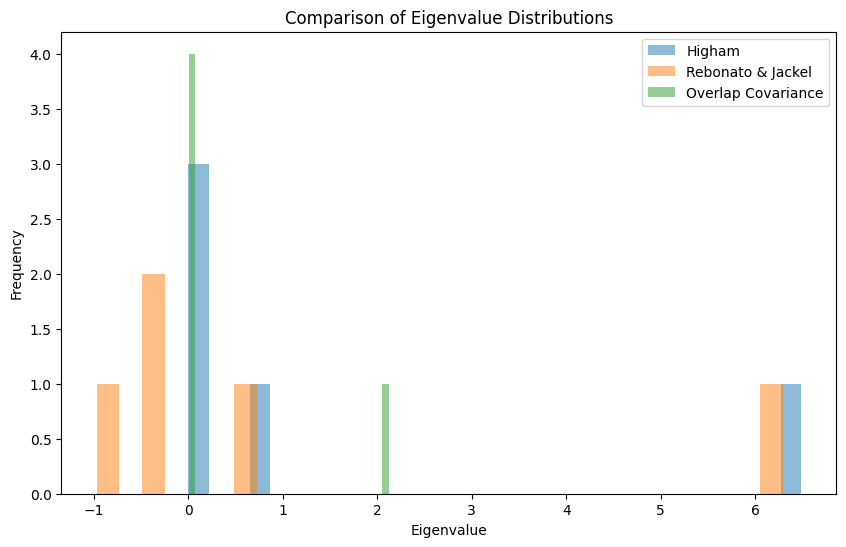

In [11]:
import matplotlib.pyplot as plt

# Calculate the eigenvalues of three matrices
eigen_higham = np.linalg.eigvals(adjusted_higham)
eigen_rj = np.linalg.eigvals(adjusted_rj)
eigen_overlap = np.linalg.eigvals(overlap_cov_matrix)

# Plot eigenvalue distribution
plt.figure(figsize=(10, 6))
plt.hist(eigen_higham, bins=30, alpha=0.5, label="Higham")
plt.hist(eigen_rj, bins=30, alpha=0.5, label="Rebonato & Jackel")
plt.hist(eigen_overlap, bins=30, alpha=0.5, label="Overlap Covariance")
plt.legend()
plt.xlabel("Eigenvalue")
plt.ylabel("Frequency")
plt.title("Comparison of Eigenvalue Distributions")
plt.show()

In [12]:
eigen_higham

array([ 6.48478357e+00,  7.20862351e-01, -7.45423708e-07, -1.14163760e-06,
       -1.04386991e-06])

In [13]:
eigen_rj

array([ 6.29603063,  0.55311472, -0.97183577, -0.48596196, -0.39134762])

In [14]:
eigen_overlap

array([2.12083697, 0.01897221, 0.01112963, 0.00519785, 0.0041588 ])